# Analisis Experimental


Este cuaderno implementa un conjunto amplio de experimentos siguiendo el informe.
Se comparan: kernelizacion + Kruskal modificado, metodo dual, CH, AH y fuerza bruta
(solo en instancias pequenas). Las heuristicas pueden quedar atrapadas en optimos
locales y no encontrar un arbol factible aunque exista; en ese caso registramos
el intento como fallo sin esperar fuerza bruta salvo cuando sea viable.


In [23]:
import math
import random
import time
import statistics as stats
from collections import defaultdict

import networkx as nx
import matplotlib.pyplot as plt

from utils import get_cost, is_feasable
from instance_generator import generate_instance
from kernelization import reduction_dcmst, kruskal_dcst
from heuristics import dual_method
from ch import CH_Heuristic
from ah import AH_Heuristic
from bruteforce import bruteforce

plt.style.use("seaborn-v0_8")


In [24]:
def build_graph(edges):
    G = nx.Graph()
    G.add_weighted_edges_from(edges)
    return G

def record_result(results, name, tree, degree_bounds, elapsed):
    feasible = nx.is_tree(tree) and is_feasable(degree_bounds, tree)
    cost = get_cost(tree) if feasible else math.inf
    results.append({
        "algo": name,
        "feasible": feasible,
        "cost": float(cost),
        "time": elapsed,
        "edges_in_tree": len(tree.edges),
    })

def compute_mst_reference(G, degree_bounds):
    mst = nx.minimum_spanning_tree(G)
    cost = get_cost(mst)
    violations = sum(1 for v in mst.nodes if mst.degree(v) > degree_bounds[v])
    excess = sum(max(0, mst.degree(v) - degree_bounds[v]) for v in mst.nodes)
    return {"mst_cost": float(cost), "mst_violations": violations, "mst_excess": excess}


def evaluate_algorithms(G, degree_bounds, run_bruteforce=False, brute_force_edge_limit=12):
    algo_results = []

    start = time.perf_counter()
    G_red, T_star = reduction_dcmst(G, degree_bounds)
    T_kernel = kruskal_dcst(G_red, T_star, degree_bounds)
    record_result(algo_results, "Kernel+Kruskal", T_kernel, degree_bounds, time.perf_counter() - start)

    start = time.perf_counter()
    mst_base = nx.minimum_spanning_tree(G)
    T_dual = dual_method(G, mst_base.copy(), degree_bounds)
    record_result(algo_results, "Dual method", T_dual, degree_bounds, time.perf_counter() - start)

    start = time.perf_counter()
    cost_ch, T_ch = CH_Heuristic(G, degree_bounds)
    record_result(algo_results, "CH", T_ch, degree_bounds, time.perf_counter() - start)
    algo_results[-1]["reported_cost"] = cost_ch

    start = time.perf_counter()
    cost_ah, T_ah = AH_Heuristic(G, degree_bounds, C_max=None)
    record_result(algo_results, "AH", T_ah, degree_bounds, time.perf_counter() - start)
    algo_results[-1]["reported_cost"] = cost_ah

    if run_bruteforce and len(G.edges) <= brute_force_edge_limit:
        start = time.perf_counter()
        bf_cost, _ = bruteforce(G, degree_bounds)
        elapsed = time.perf_counter() - start
        feasible = math.isfinite(bf_cost)
        algo_results.append({
            "algo": "Bruteforce",
            "feasible": feasible,
            "cost": float(bf_cost if feasible else math.inf),
            "time": elapsed,
            "edges_in_tree": len(G.edges) if feasible else 0,
        })
    
    feasible_costs = [r["cost"] for r in algo_results if r["feasible"]]
    best_cost = min(feasible_costs) if feasible_costs else math.inf
    for r in algo_results:
        r["best_cost"] = best_cost
        if math.isfinite(best_cost) and r["feasible"]:
            r["gap_vs_best"] = (r["cost"] - best_cost) / best_cost * 100
        else:
            r["gap_vs_best"] = None
    return algo_results


def run_batch(sizes, seeds_per_size=3, brute_force_edge_limit=0, edge_prob=0.4, violation_prob=0.4):
    records = []
    for n in sizes:
        for s_idx in range(seeds_per_size):
            seed = 10_000 + n * 100 + s_idx
            edges, degree_bounds = generate_instance(n, edge_prob=edge_prob, violation_prob=violation_prob, seed=seed)
            G = build_graph(edges)
            run_bf = brute_force_edge_limit and len(G.edges) <= brute_force_edge_limit
            instance_results = evaluate_algorithms(G, degree_bounds, run_bruteforce=run_bf, brute_force_edge_limit=brute_force_edge_limit)
            for r in instance_results:
                r.update({"n": n, "m": len(G.edges), "seed": seed, "ran_bruteforce": run_bf, "edge_prob": edge_prob, "violation_prob": violation_prob})
            records.extend(instance_results)
    return records


def summarize_records(records, algos):
    summary = []
    by_algo = defaultdict(list)
    for r in records:
        by_algo[r["algo"]].append(r)
    for algo in algos:
        rows = by_algo.get(algo, [])
        if not rows:
            continue
        feasible_rate = sum(1 for r in rows if r["feasible"]) / len(rows)
        gaps = [r.get("gap_vs_best") for r in rows if r.get("gap_vs_best") is not None]
        avg_gap = stats.mean(gaps) if gaps else None
        times = [r["time"] for r in rows]
        summary.append({"algo": algo, "feasible_rate": feasible_rate, "avg_gap": avg_gap, "avg_time": stats.mean(times)})
    return summary


def plot_success_rate(records, algos, title):
    plt.figure(figsize=(7,4))
    for algo in algos:
        grouped = defaultdict(list)
        for r in records:
            if r["algo"] == algo:
                grouped[r["n"]].append(r["feasible"])
        if not grouped:
            continue
        xs = sorted(grouped)
        ys = [100 * sum(grouped[n]) / len(grouped[n]) for n in xs]
        plt.plot(xs, ys, marker="o", label=algo)
    plt.ylim(0, 105)
    plt.xlabel("n (vertices)")
    plt.ylabel("instancias factibles (%)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def plot_cost_gap(records, algos, title):
    plt.figure(figsize=(7,4))
    for algo in algos:
        grouped = defaultdict(list)
        for r in records:
            if r["algo"] == algo and r["gap_vs_best"] is not None:
                grouped[r["n"]].append(r["gap_vs_best"])
        if not grouped:
            continue
        xs = sorted(grouped)
        ys = [stats.mean(grouped[n]) for n in xs]
        plt.plot(xs, ys, marker="o", label=algo)
    plt.xlabel("n (vertices)")
    plt.ylabel("brecha de costo vs mejor (%)")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def plot_time(records, algos, title):
    plt.figure(figsize=(7,4))
    for algo in algos:
        grouped = defaultdict(list)
        for r in records:
            if r["algo"] == algo:
                grouped[r["n"]].append(r["time"])
        if not grouped:
            continue
        xs = sorted(grouped)
        ys = [stats.mean(grouped[n]) for n in xs]
        plt.plot(xs, ys, marker="o", label=algo)
    plt.xlabel("n (vertices)")
    plt.ylabel("tiempo promedio (s)")
    plt.title(title)
    plt.yscale("log")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def permute_graph(G, degree_bounds, seed):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    perm = nodes[:]
    rng.shuffle(perm)
    mapping = {nodes[i]: perm[i] for i in range(len(nodes))}
    G_perm = nx.relabel_nodes(G, mapping, copy=True)
    bounds_perm = {mapping[k]: v for k, v in degree_bounds.items()}
    return G_perm, bounds_perm


def run_restarts(G, degree_bounds, algo_fn, restarts=5, seed_base=123):
    best_cost = math.inf
    best_time = 0.0
    best_feasible = False
    for i in range(restarts):
        Gp, bp = permute_graph(G, degree_bounds, seed_base + i)
        start = time.perf_counter()
        cost, T = algo_fn(Gp, bp)
        elapsed = time.perf_counter() - start
        feasible = nx.is_tree(T) and is_feasable(bp, T)
        if feasible and cost < best_cost:
            best_cost = cost
            best_time = elapsed
            best_feasible = True
    return {"feasible": best_feasible, "cost": float(best_cost), "time": best_time}


def kernel_stats(G, degree_bounds):
    start = time.perf_counter()
    G_red, T_star = reduction_dcmst(G, degree_bounds)
    elapsed = time.perf_counter() - start
    fixed_edges = len(T_star.edges)
    total_edges = len(G.edges)
    return {"fixed_edges": fixed_edges, "total_edges": total_edges, "fixed_ratio": fixed_edges / total_edges if total_edges else 0.0, "time": elapsed}


def heatmap(data, xlabels, ylabels, title, cmap="viridis"):
    plt.figure(figsize=(6,4))
    plt.imshow(data, cmap=cmap, aspect="auto", origin="lower")
    plt.colorbar()
    plt.xticks(range(len(xlabels)), xlabels)
    plt.yticks(range(len(ylabels)), ylabels)
    plt.title(title)
    plt.xlabel("edge_prob")
    plt.ylabel("violation_prob")
    plt.show()


def capped_kruskal(G, degree_bounds):
    parent = {v: v for v in G.nodes}

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(a, b):
        ra, rb = find(a), find(b)
        if ra == rb:
            return False
        parent[rb] = ra
        return True

    T = nx.Graph()
    T.add_nodes_from(G.nodes)
    edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])
    for u, v, w in edges:
        if T.degree(u) + 1 > degree_bounds[u]:
            continue
        if T.degree(v) + 1 > degree_bounds[v]:
            continue
        if union(u, v):
            T.add_edge(u, v, weight=w['weight'])
        if len(T.edges) == len(G.nodes) - 1:
            break
    return T


def capped_prim(G, degree_bounds, start=None):
    if start is None:
        start = next(iter(G.nodes))
    T = nx.Graph()
    T.add_nodes_from(G.nodes)
    visited = set([start])
    edges = []
    for v in G.neighbors(start):
        edges.append((G[start][v]['weight'], start, v))
    import heapq
    heapq.heapify(edges)

    while edges and len(visited) < len(G.nodes):
        w, u, v = heapq.heappop(edges)
        if v in visited:
            continue
        if T.degree(u) + 1 > degree_bounds[u]:
            continue
        if T.degree(v) + 1 > degree_bounds[v]:
            continue
        T.add_edge(u, v, weight=w)
        visited.add(v)
        for nxt in G.neighbors(v):
            if nxt not in visited:
                heapq.heappush(edges, (G[v][nxt]['weight'], v, nxt))
    return T


def run_ilp_exact(G, degree_bounds, time_limit=10):
    try:
        import pulp
    except Exception:
        return None

    nodes = list(G.nodes)
    edges = list(G.edges(data=True))
    n = len(nodes)
    root = nodes[0]

    model = pulp.LpProblem('dcmst', pulp.LpMinimize)

    x = {}
    for u, v, w in edges:
        key = (u, v) if u <= v else (v, u)
        x[key] = pulp.LpVariable(f"x_{key[0]}_{key[1]}", 0, 1, cat='Binary')

    arcs = []
    for u, v, w in edges:
        arcs.append((u, v))
        arcs.append((v, u))
    f = {a: pulp.LpVariable(f"f_{a[0]}_{a[1]}", 0, n - 1, cat='Continuous') for a in arcs}

    model += pulp.lpSum([w['weight'] * x[(u, v) if u <= v else (v, u)] for u, v, w in edges])
    model += pulp.lpSum([x[(u, v) if u <= v else (v, u)] for u, v, _ in edges]) == n - 1

    for v in nodes:
        incident = []
        for u in G.neighbors(v):
            key = (u, v) if u <= v else (v, u)
            incident.append(x[key])
        model += pulp.lpSum(incident) <= degree_bounds[v]

    for v in nodes:
        in_flow = [f[(u, v)] for u in G.neighbors(v)]
        out_flow = [f[(v, u)] for u in G.neighbors(v)]
        if v == root:
            model += pulp.lpSum(out_flow) - pulp.lpSum(in_flow) == n - 1
        else:
            model += pulp.lpSum(in_flow) - pulp.lpSum(out_flow) == 1

    for u, v, w in edges:
        key = (u, v) if u <= v else (v, u)
        model += f[(u, v)] <= (n - 1) * x[key]
        model += f[(v, u)] <= (n - 1) * x[key]

    solver = pulp.PULP_CBC_CMD(msg=False, timeLimit=time_limit)
    model.solve(solver)

    if model.status != pulp.LpStatusOptimal and model.status != pulp.LpStatusNotSolved:
        return {"status": pulp.LpStatus[model.status], "cost": math.inf, "tree": nx.Graph()}

    T = nx.Graph()
    T.add_nodes_from(G.nodes)
    for u, v, w in edges:
        key = (u, v) if u <= v else (v, u)
        if pulp.value(x[key]) >= 0.5:
            T.add_edge(u, v, weight=w['weight'])

    cost = get_cost(T) if nx.is_tree(T) else math.inf
    return {"status": pulp.LpStatus[model.status], "cost": float(cost), "tree": T}


## Experimento 1: instancias pequenas con referencia optima
- n en [5,8], 4 semillas por tamano.
- Se intenta fuerza bruta solo si hay pocas aristas (<=12) para usarla como optimo.
- Objetivo: medir tasa de factibilidad y brecha de costo frente al mejor costo hallado.


Resumen global (promedios sobre instancias generadas):
- Kernel+Kruskal: factible=68.8% | brecha promedio=0.00% | tiempo medio=0.0007s
- Dual method: factible=68.8% | brecha promedio=6.82% | tiempo medio=0.0007s
- CH: factible=75.0% | brecha promedio=7.12% | tiempo medio=0.0009s
- AH: factible=68.8% | brecha promedio=0.00% | tiempo medio=0.0006s
- Bruteforce: factible=90.0% | brecha promedio=0.00% | tiempo medio=0.0748s


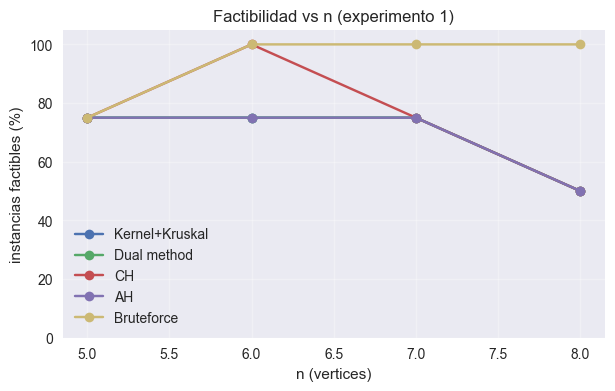

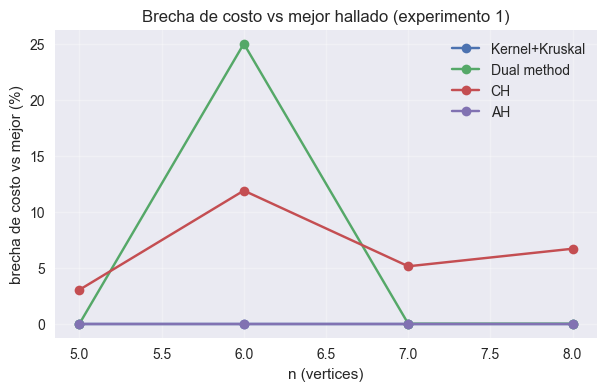

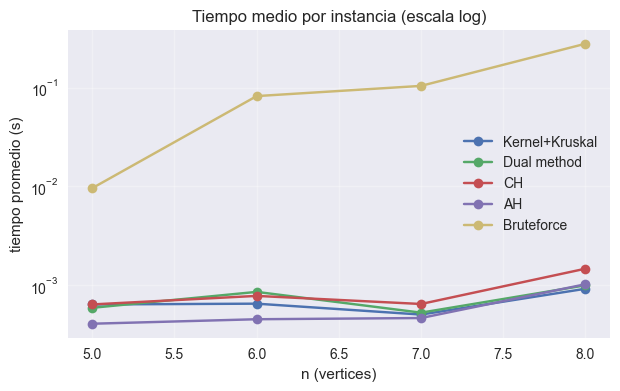

In [25]:
small_sizes = list(range(5, 9))
baseline_records = run_batch(small_sizes, seeds_per_size=4, brute_force_edge_limit=12)

algos_full = ["Kernel+Kruskal", "Dual method", "CH", "AH", "Bruteforce"]
print("Resumen global (promedios sobre instancias generadas):")
for row in summarize_records(baseline_records, algos_full):
    gap_txt = f"{row['avg_gap']:.2f}%" if row["avg_gap"] is not None else "nan"
    print(f"- {row['algo']}: factible={row['feasible_rate']*100:.1f}% | brecha promedio={gap_txt} | tiempo medio={row['avg_time']:.4f}s")

plot_success_rate(baseline_records, algos_full, "Factibilidad vs n (experimento 1)")
plot_cost_gap(baseline_records, algos_full[:-1], "Brecha de costo vs mejor hallado (experimento 1)")
plot_time(baseline_records, algos_full, "Tiempo medio por instancia (escala log)")


Comentarios esperados:
- CH y AH suelen ser rapidas; la calidad depende de cuan ajustadas esten las cotas.
- Kernel+Kruskal es muy rapido y puede fallar cuando los limites son muy estrictos.
- Fuerza bruta sirve solo como referencia de optimo en instancias pequenas.


## Experimento 2: escalabilidad en n
- n en [10,15,20,30,40,50], 3 semillas por tamano.
- Se desactiva fuerza bruta; solo heuristicas y kernelizacion.
- Objetivo: ver como escala el tiempo y la factibilidad.


Resumen global (experimento 2):
- Kernel+Kruskal: factible=72.2% | brecha promedio=0.37% | tiempo medio=0.0057s
- Dual method: factible=83.3% | brecha promedio=3.42% | tiempo medio=0.0188s
- CH: factible=88.9% | brecha promedio=9.93% | tiempo medio=0.0095s
- AH: factible=38.9% | brecha promedio=1.01% | tiempo medio=0.0110s


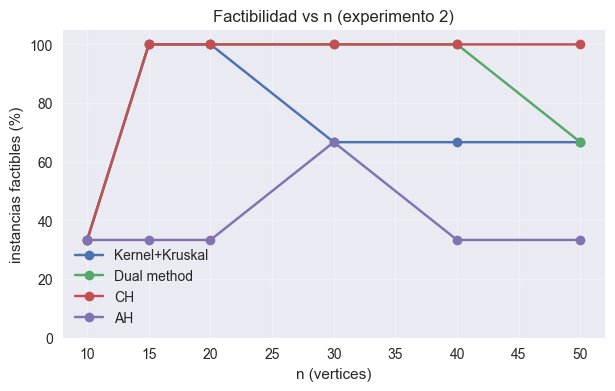

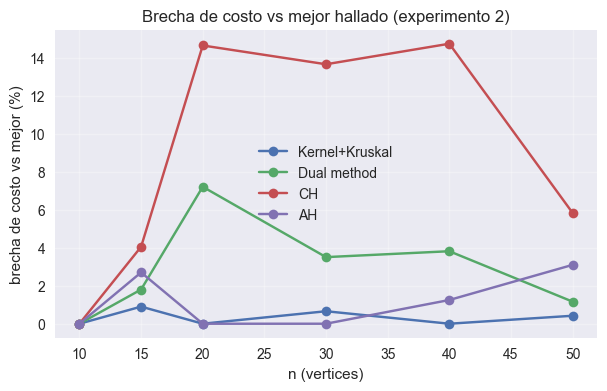

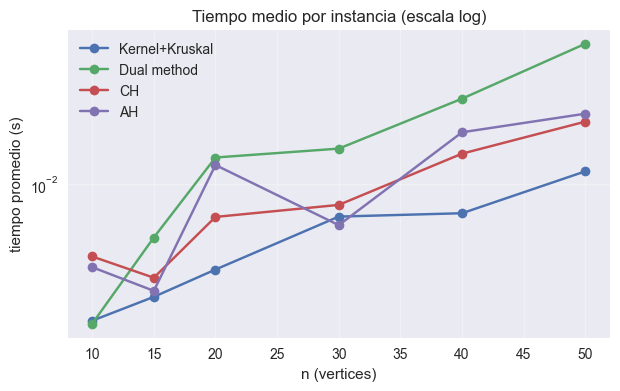

In [26]:
large_sizes = [10, 15, 20, 30, 40, 50]
scaling_records = run_batch(large_sizes, seeds_per_size=3, brute_force_edge_limit=0)
algos_light = ["Kernel+Kruskal", "Dual method", "CH", "AH"]

print("Resumen global (experimento 2):")
for row in summarize_records(scaling_records, algos_light):
    gap_txt = f"{row['avg_gap']:.2f}%" if row["avg_gap"] is not None else "nan"
    print(f"- {row['algo']}: factible={row['feasible_rate']*100:.1f}% | brecha promedio={gap_txt} | tiempo medio={row['avg_time']:.4f}s")

plot_success_rate(scaling_records, algos_light, "Factibilidad vs n (experimento 2)")
plot_cost_gap(scaling_records, algos_light, "Brecha de costo vs mejor hallado (experimento 2)")
plot_time(scaling_records, algos_light, "Tiempo medio por instancia (escala log)")


Observaciones:
- Si cae la factibilidad para CH/AH, es indicio de optimo local.
- Kernel+Kruskal tiende a mantener tiempo bajo aun con n alto.


## Experimento 3: sensibilidad a densidad y restricciones
- Barrido de edge_prob y violation_prob con n fijo.
- Objetivo: ver como cambia factibilidad y brecha segun densidad y severidad.


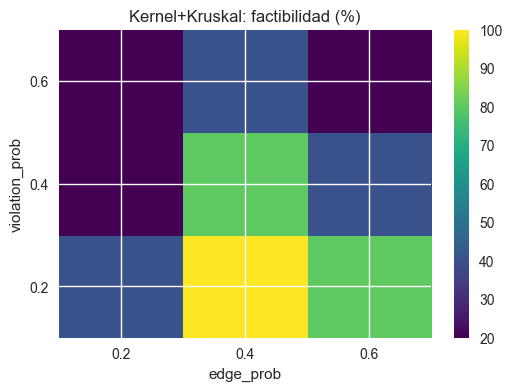

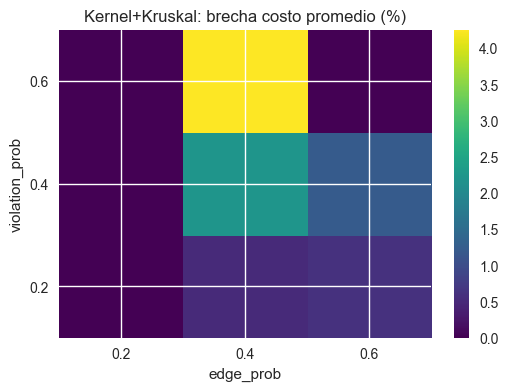

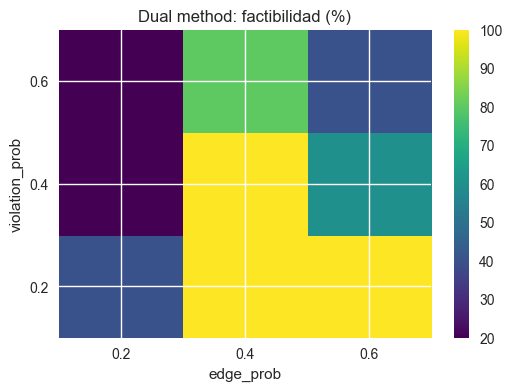

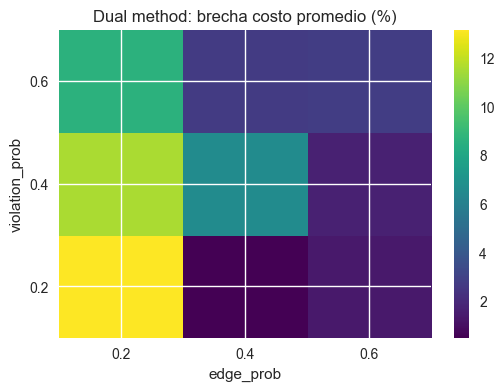

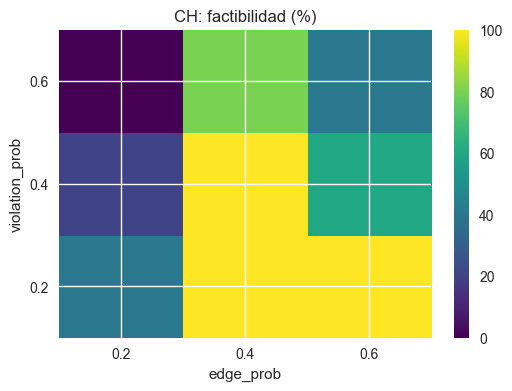

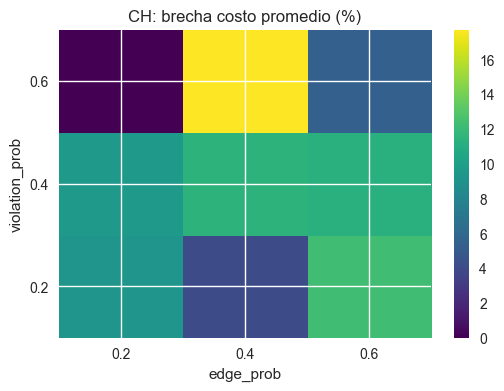

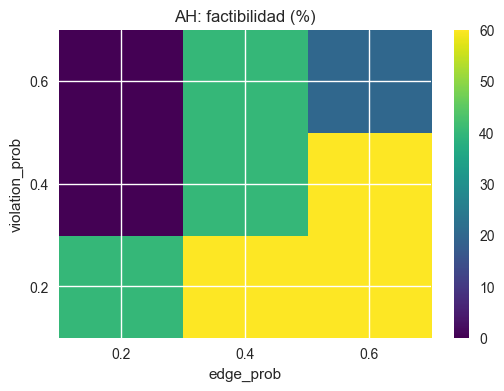

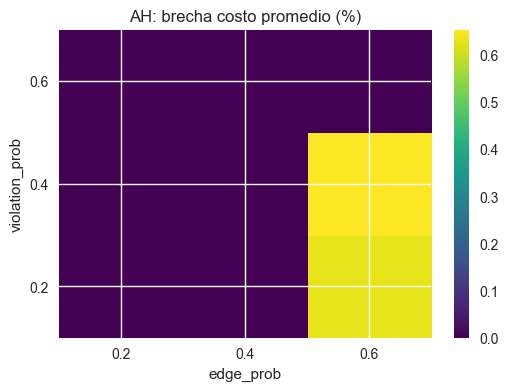

In [27]:
edge_probs = [0.2, 0.4, 0.6]
violation_probs = [0.2, 0.4, 0.6]
base_n = 20
seeds = 5
algos = ["Kernel+Kruskal", "Dual method", "CH", "AH"]

records = []
for ep in edge_probs:
    for vp in violation_probs:
        records.extend(run_batch([base_n], seeds_per_size=seeds, brute_force_edge_limit=0, edge_prob=ep, violation_prob=vp))

for algo in algos:
    feas_matrix = []
    gap_matrix = []
    for vp in violation_probs:
        row_feas = []
        row_gap = []
        for ep in edge_probs:
            rows = [r for r in records if r["algo"] == algo and r["edge_prob"] == ep and r["violation_prob"] == vp]
            if not rows:
                row_feas.append(0)
                row_gap.append(0)
                continue
            row_feas.append(100 * sum(1 for r in rows if r["feasible"]) / len(rows))
            gaps = [r["gap_vs_best"] for r in rows if r["gap_vs_best"] is not None]
            row_gap.append(stats.mean(gaps) if gaps else 0)
        feas_matrix.append(row_feas)
        gap_matrix.append(row_gap)
    heatmap(feas_matrix, edge_probs, violation_probs, f"{algo}: factibilidad (%)")
    heatmap(gap_matrix, edge_probs, violation_probs, f"{algo}: brecha costo promedio (%)")


Interpretacion:
- edge_prob bajo y violation_prob alto suelen reducir factibilidad.
- Si la brecha crece mucho, el algoritmo se aleja del mejor factible encontrado.


## Experimento 4: robustez por semillas
- n fijo, muchas semillas.
- Objetivo: medir estabilidad de costo y factibilidad.


Kernel+Kruskal: gap media=0.20% | std=0.49
Dual method: gap media=2.97% | std=3.58
CH: gap media=9.10% | std=6.70
AH: gap media=0.17% | std=0.47


C:\Users\Melani Forsythe\AppData\Local\Temp\ipykernel_6828\792471080.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=algos)


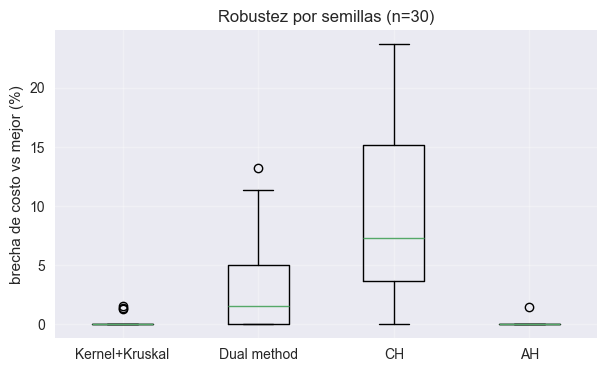

In [28]:
n_fixed = 30
seeds = 30
records = run_batch([n_fixed], seeds_per_size=seeds, brute_force_edge_limit=0)
algos = ["Kernel+Kruskal", "Dual method", "CH", "AH"]

for algo in algos:
    gaps = [r["gap_vs_best"] for r in records if r["algo"] == algo and r["gap_vs_best"] is not None]
    print(f"{algo}: gap media={stats.mean(gaps) if gaps else float('nan'):.2f}% | std={stats.pstdev(gaps) if gaps else float('nan'):.2f}")

plt.figure(figsize=(7,4))
box_data = [
    [r["gap_vs_best"] for r in records if r["algo"] == algo and r["gap_vs_best"] is not None]
    for algo in algos
]
plt.boxplot(box_data, labels=algos)
plt.ylabel("brecha de costo vs mejor (%)")
plt.title("Robustez por semillas (n=30)")
plt.grid(True, alpha=0.3)
plt.show()


Interpretacion:
- Una caja mas compacta indica mayor estabilidad.
- Si hay muchos outliers, el metodo es sensible a la instancia.


## Experimento 5: reinicios (CH y AH)
- Se relabelan nodos para generar diferentes recorridos iniciales.
- Objetivo: ver si varios reinicios reducen brecha de costo.


In [29]:
n_fixed = 30
seeds = 10
restarts = 5
records = []
for s_idx in range(seeds):
    seed = 20_000 + s_idx
    edges, degree_bounds = generate_instance(n_fixed, seed=seed)
    G = build_graph(edges)

    # ejecucion simple
    cost_ch, T_ch = CH_Heuristic(G, degree_bounds)
    feasible_ch = nx.is_tree(T_ch) and is_feasable(degree_bounds, T_ch)
    cost_ah, T_ah = AH_Heuristic(G, degree_bounds)
    feasible_ah = nx.is_tree(T_ah) and is_feasable(degree_bounds, T_ah)

    # reinicios
    ch_restart = run_restarts(G, degree_bounds, CH_Heuristic, restarts=restarts, seed_base=seed)
    ah_restart = run_restarts(G, degree_bounds, AH_Heuristic, restarts=restarts, seed_base=seed)

    records.append({"algo": "CH", "mode": "single", "feasible": feasible_ch, "cost": cost_ch})
    records.append({"algo": "CH", "mode": "restart", "feasible": ch_restart["feasible"], "cost": ch_restart["cost"]})
    records.append({"algo": "AH", "mode": "single", "feasible": feasible_ah, "cost": cost_ah})
    records.append({"algo": "AH", "mode": "restart", "feasible": ah_restart["feasible"], "cost": ah_restart["cost"]})

for algo in ["CH", "AH"]:
    single = [r["cost"] for r in records if r["algo"] == algo and r["mode"] == "single" and math.isfinite(r["cost"])]
    restart = [r["cost"] for r in records if r["algo"] == algo and r["mode"] == "restart" and math.isfinite(r["cost"])]
    print(f"{algo}: single={stats.mean(single) if single else float('nan'):.2f} | restart={stats.mean(restart) if restart else float('nan'):.2f}")


CH: single=79.00 | restart=78.50
AH: single=69.40 | restart=71.50


Interpretacion:
- Si restart reduce el costo medio, conviene usar varios arranques.
- El costo computacional aumenta linealmente con el numero de reinicios.


## Experimento 6: referencia MST sin restricciones
- Compara costo del MST clasico (inviable) contra el mejor factible.
- Objetivo: estimar el costo adicional por respetar grados.


MST costo medio: 37.13
Mejor factible medio: 50.36
Violaciones promedio en MST: 3.47


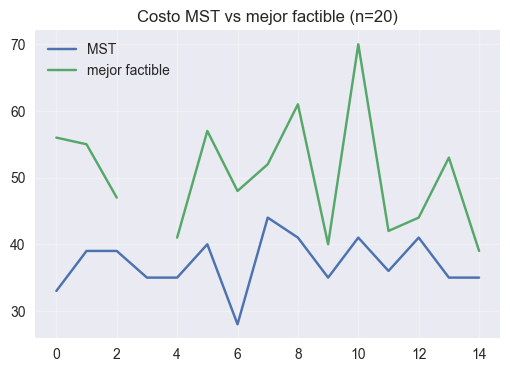

In [30]:
n_fixed = 20
seeds = 15
mst_costs = []
best_costs = []
violations = []

for s_idx in range(seeds):
    seed = 30_000 + s_idx
    edges, degree_bounds = generate_instance(n_fixed, seed=seed)
    G = build_graph(edges)

    ref = compute_mst_reference(G, degree_bounds)
    mst_costs.append(ref["mst_cost"])
    violations.append(ref["mst_violations"])

    results = evaluate_algorithms(G, degree_bounds)
    feasible_costs = [r["cost"] for r in results if r["feasible"]]
    best_costs.append(min(feasible_costs) if feasible_costs else math.inf)

print(f"MST costo medio: {stats.mean(mst_costs):.2f}")
print(f"Mejor factible medio: {stats.mean([c for c in best_costs if math.isfinite(c)]):.2f}")
print(f"Violaciones promedio en MST: {stats.mean(violations):.2f}")

plt.figure(figsize=(6,4))
plt.plot(mst_costs, label="MST")
plt.plot(best_costs, label="mejor factible")
plt.legend()
plt.title("Costo MST vs mejor factible (n=20)")
plt.grid(True, alpha=0.3)
plt.show()


Interpretacion:
- La diferencia entre curvas es el costo por respetar restricciones.
- Muchas violaciones en MST indican cotas muy estrictas.


## Experimento 7: restricciones muy estrictas
- Se fuerza d(v) = min(grado en G, 2).
- Objetivo: medir como cae la factibilidad en escenarios extremos.


In [31]:
n_fixed = 25
seeds = 10
algos = ["Kernel+Kruskal", "Dual method", "CH", "AH"]
records = []

for s_idx in range(seeds):
    seed = 40_000 + s_idx
    edges, degree_bounds = generate_instance(n_fixed, seed=seed)
    G = build_graph(edges)

    strict_bounds = {v: min(G.degree(v), 2) for v in G.nodes}
    results = evaluate_algorithms(G, strict_bounds)
    for r in results:
        records.append(r)

print("Factibilidad con restricciones estrictas:")
for row in summarize_records(records, algos):
    print(f"- {row['algo']}: factible={row['feasible_rate']*100:.1f}% | tiempo medio={row['avg_time']:.4f}s")


Factibilidad con restricciones estrictas:
- Kernel+Kruskal: factible=50.0% | tiempo medio=0.0051s
- Dual method: factible=90.0% | tiempo medio=0.0251s
- CH: factible=100.0% | tiempo medio=0.0095s
- AH: factible=40.0% | tiempo medio=0.0117s


Interpretacion:
- Si la factibilidad se desploma, el problema se acerca a un camino hamiltoniano.
- Es normal que heuristicas fallen por optimos locales.


## Experimento 8: impacto de kernelizacion
- Mide porcentaje de aristas fijadas por la reduccion.
- Objetivo: relacionar reduccion con tiempo y factibilidad.


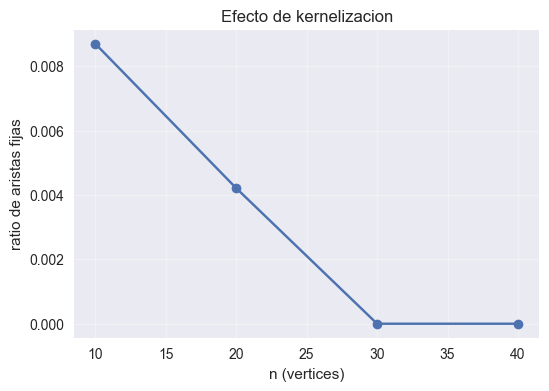

In [32]:
sizes = [10, 20, 30, 40]
seeds = 5
ratios = defaultdict(list)

for n in sizes:
    for s_idx in range(seeds):
        seed = 50_000 + n * 10 + s_idx
        edges, degree_bounds = generate_instance(n, seed=seed)
        G = build_graph(edges)
        stats_k = kernel_stats(G, degree_bounds)
        ratios[n].append(stats_k["fixed_ratio"])

avg_ratios = [stats.mean(ratios[n]) for n in sizes]
plt.figure(figsize=(6,4))
plt.plot(sizes, avg_ratios, marker="o")
plt.xlabel("n (vertices)")
plt.ylabel("ratio de aristas fijas")
plt.title("Efecto de kernelizacion")
plt.grid(True, alpha=0.3)
plt.show()


Interpretacion:
- Un ratio alto indica que la reduccion fija gran parte del arbol.
- En esos casos, Kernel+Kruskal suele mejorar factibilidad y tiempo.


## Experimento 9: hibridos encadenados
- Se usa la salida de Kernel+Kruskal como entrada del metodo dual.
- Objetivo: ver si mejora factibilidad o costo frente al dual sobre MST.


In [33]:
n_fixed = 25
seeds = 10
records = []

for s_idx in range(seeds):
    seed = 60_000 + s_idx
    edges, degree_bounds = generate_instance(n_fixed, seed=seed)
    G = build_graph(edges)

    # Dual sobre MST
    start = time.perf_counter()
    mst_base = nx.minimum_spanning_tree(G)
    T_dual = dual_method(G, mst_base.copy(), degree_bounds)
    record_result(records, "Dual method", T_dual, degree_bounds, time.perf_counter() - start)

    # Kernel+Kruskal
    G_red, T_star = reduction_dcmst(G, degree_bounds)
    T_kernel = kruskal_dcst(G_red, T_star, degree_bounds)

    # Dual sobre salida kernel (si es arbol)
    if nx.is_tree(T_kernel):
        start = time.perf_counter()
        T_hybrid = dual_method(G, T_kernel.copy(), degree_bounds)
        record_result(records, "Kernel+Dual", T_hybrid, degree_bounds, time.perf_counter() - start)

algos = ["Dual method", "Kernel+Dual"]
for row in summarize_records(records, algos):
    gap_txt = f"{row['avg_gap']:.2f}%" if row["avg_gap"] is not None else "nan"
    print(f"- {row['algo']}: factible={row['feasible_rate']*100:.1f}% | brecha promedio={gap_txt} | tiempo medio={row['avg_time']:.4f}s")


- Dual method: factible=80.0% | brecha promedio=nan | tiempo medio=0.0114s
- Kernel+Dual: factible=100.0% | brecha promedio=nan | tiempo medio=0.0003s


Interpretacion:
- Si Kernel+Dual mejora factibilidad, la reduccion ayuda a escapar de optimos locales.
- Si no mejora, el costo extra de kernelizacion puede no compensar.


## Experimento 10: exacto por fuerza bruta (solo muy pequeno)
- Usa fuerza bruta como referencia exacta cuando n <= 9 y m <= 12.
- Sirve para comparar la brecha real de las heuristicas.
- Si la instancia es mas grande, se omite para evitar tiempos excesivos.


In [39]:
sizes = [6, 7, 8, 9]
seeds = 3
algos = ["Kernel+Kruskal", "Dual method", "CH", "AH"]

records = []
for n in sizes:
    for s_idx in range(seeds):
        seed = 70_000 + n * 10 + s_idx
        edges, degree_bounds = generate_instance(n, seed=seed)
        G = build_graph(edges)

        if len(G.edges) > 12:
            print(f"Se omite fuerza bruta para n={n} con m={len(G.edges)}")
            continue

        bf_cost, _ = bruteforce(G, degree_bounds)
        if not math.isfinite(bf_cost):
            continue

        results = evaluate_algorithms(G, degree_bounds)
        for r in results:
            if r["algo"] in algos and r["feasible"]:
                r["gap_vs_exact"] = (r["cost"] - bf_cost) / bf_cost * 100
                records.append(r)

for algo in algos:
    gaps = [r["gap_vs_exact"] for r in records if r["algo"] == algo and r.get("gap_vs_exact") is not None]
    print(f"{algo}: gap medio vs exacto = {stats.mean(gaps) if gaps else float('nan'):.2f}%")


Se omite fuerza bruta para n=7 con m=13
Se omite fuerza bruta para n=7 con m=14
Se omite fuerza bruta para n=8 con m=20
Se omite fuerza bruta para n=8 con m=15
Se omite fuerza bruta para n=8 con m=24
Se omite fuerza bruta para n=9 con m=21
Se omite fuerza bruta para n=9 con m=20
Se omite fuerza bruta para n=9 con m=19
Kernel+Kruskal: gap medio vs exacto = 0.00%
Dual method: gap medio vs exacto = 13.33%
CH: gap medio vs exacto = 0.00%
AH: gap medio vs exacto = 0.00%


Interpretacion:
- La brecha vs ILP muestra cuanto se aleja cada heuristica del optimo exacto.
- Si ILP no esta disponible, se omite este experimento.


## Experimento 11: sensibilidad al rango de pesos
- Se varia w_max manteniendo w_min fijo.
- Objetivo: ver si pesos mas dispersos dificultan las heuristicas.


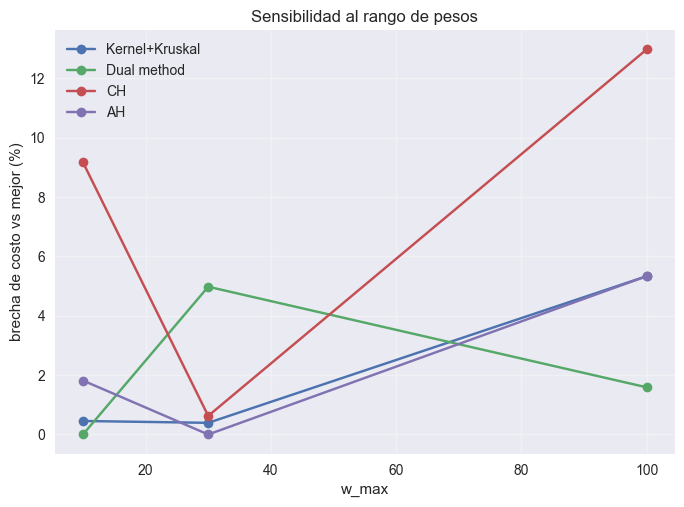

In [35]:
n_fixed = 20
seeds = 5
w_max_values = [10, 30, 100]
algos = ["Kernel+Kruskal", "Dual method", "CH", "AH"]

records = []
for w_max in w_max_values:
    for s_idx in range(seeds):
        seed = 80_000 + w_max + s_idx
        edges, degree_bounds = generate_instance(n_fixed, w_min=1, w_max=w_max, seed=seed)
        G = build_graph(edges)
        results = evaluate_algorithms(G, degree_bounds)
        for r in results:
            r["w_max"] = w_max
            records.append(r)

for algo in algos:
    means = []
    for w_max in w_max_values:
        gaps = [r["gap_vs_best"] for r in records if r["algo"] == algo and r["w_max"] == w_max and r["gap_vs_best"] is not None]
        means.append(stats.mean(gaps) if gaps else 0)
    plt.plot(w_max_values, means, marker="o", label=algo)

plt.xlabel("w_max")
plt.ylabel("brecha de costo vs mejor (%)")
plt.title("Sensibilidad al rango de pesos")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Interpretacion:
- Si la brecha crece con w_max, los pesos dispersos dificultan las mejoras locales.


## Experimento 12: cuellos de botella
- Se analiza la relacion entre cotas pequenas y factibilidad.
- Se usa ratio de nodos con d(v) <= 2 como indicador.


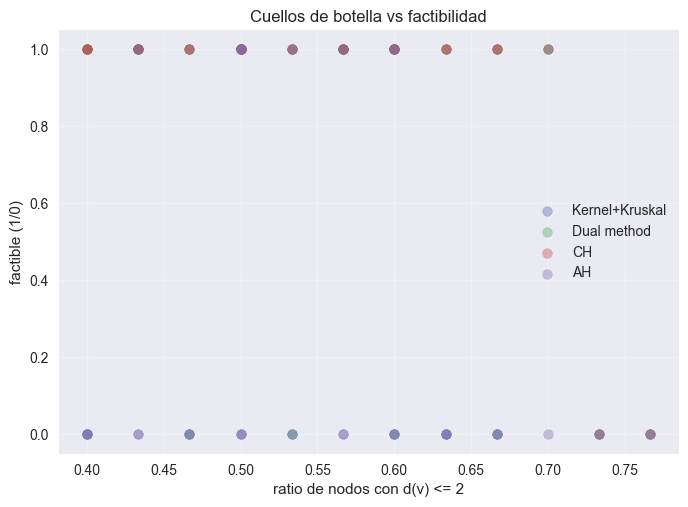

In [36]:
n_fixed = 30
seeds = 30
algos = ["Kernel+Kruskal", "Dual method", "CH", "AH"]
rows = []

for s_idx in range(seeds):
    seed = 90_000 + s_idx
    edges, degree_bounds = generate_instance(n_fixed, seed=seed)
    G = build_graph(edges)

    ratio_low_bounds = sum(1 for v in G.nodes if degree_bounds[v] <= 2) / len(G.nodes)
    results = evaluate_algorithms(G, degree_bounds)
    for r in results:
        r["low_bound_ratio"] = ratio_low_bounds
        rows.append(r)

for algo in algos:
    xs = [r["low_bound_ratio"] for r in rows if r["algo"] == algo]
    ys = [1 if r["feasible"] else 0 for r in rows if r["algo"] == algo]
    plt.scatter(xs, ys, alpha=0.4, label=algo)

plt.xlabel("ratio de nodos con d(v) <= 2")
plt.ylabel("factible (1/0)")
plt.title("Cuellos de botella vs factibilidad")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


Interpretacion:
- Ratios altos suelen reducir factibilidad, acercando el problema a caminos.


## Experimento 13: Prim/Kruskal capados
- Versiones voraces que rechazan aristas si violan grados.
- Se comparan contra las heuristicas base.


In [37]:
sizes = [10, 20, 30]
seeds = 5
records = []

for n in sizes:
    for s_idx in range(seeds):
        seed = 100_000 + n * 10 + s_idx
        edges, degree_bounds = generate_instance(n, seed=seed)
        G = build_graph(edges)

        start = time.perf_counter()
        T_ck = capped_kruskal(G, degree_bounds)
        record_result(records, "Capped Kruskal", T_ck, degree_bounds, time.perf_counter() - start)

        start = time.perf_counter()
        T_cp = capped_prim(G, degree_bounds)
        record_result(records, "Capped Prim", T_cp, degree_bounds, time.perf_counter() - start)

        results = evaluate_algorithms(G, degree_bounds)
        records.extend(results)

algos = ["Capped Kruskal", "Capped Prim", "Kernel+Kruskal", "Dual method", "CH", "AH"]
for row in summarize_records(records, algos):
    gap_txt = f"{row['avg_gap']:.2f}%" if row["avg_gap"] is not None else "nan"
    print(f"- {row['algo']}: factible={row['feasible_rate']*100:.1f}% | brecha promedio={gap_txt} | tiempo medio={row['avg_time']:.4f}s")


- Capped Kruskal: factible=46.7% | brecha promedio=nan | tiempo medio=0.0008s
- Capped Prim: factible=80.0% | brecha promedio=nan | tiempo medio=0.0005s
- Kernel+Kruskal: factible=60.0% | brecha promedio=2.85% | tiempo medio=0.0027s
- Dual method: factible=73.3% | brecha promedio=2.37% | tiempo medio=0.0083s
- CH: factible=93.3% | brecha promedio=4.72% | tiempo medio=0.0043s
- AH: factible=40.0% | brecha promedio=2.36% | tiempo medio=0.0045s


Interpretacion:
- Los greedy capados son rapidos pero pueden fallar mas.
- Sirven como linea base adicional.


## Experimento 14: conectividad residual cuando falla
- Mide cuantas componentes quedan cuando una heuristica no logra factibilidad.
- Objetivo: caracterizar el tipo de fallo.


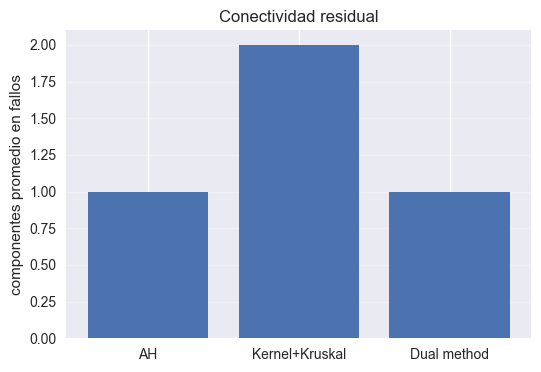

In [38]:
n_fixed = 30
seeds = 20
algos = ["Kernel+Kruskal", "Dual method", "CH", "AH"]
fail_components = defaultdict(list)

for s_idx in range(seeds):
    seed = 110_000 + s_idx
    edges, degree_bounds = generate_instance(n_fixed, seed=seed)
    G = build_graph(edges)

    # Kernel+Kruskal
    G_red, T_star = reduction_dcmst(G, degree_bounds)
    T_kernel = kruskal_dcst(G_red, T_star, degree_bounds)
    if not (nx.is_tree(T_kernel) and is_feasable(degree_bounds, T_kernel)):
        fail_components["Kernel+Kruskal"].append(nx.number_connected_components(T_kernel))

    # Dual
    mst_base = nx.minimum_spanning_tree(G)
    T_dual = dual_method(G, mst_base.copy(), degree_bounds)
    if not (nx.is_tree(T_dual) and is_feasable(degree_bounds, T_dual)):
        fail_components["Dual method"].append(nx.number_connected_components(T_dual))

    # CH
    _, T_ch = CH_Heuristic(G, degree_bounds)
    if not (nx.is_tree(T_ch) and is_feasable(degree_bounds, T_ch)):
        fail_components["CH"].append(nx.number_connected_components(T_ch))

    # AH
    _, T_ah = AH_Heuristic(G, degree_bounds)
    if not (nx.is_tree(T_ah) and is_feasable(degree_bounds, T_ah)):
        fail_components["AH"].append(nx.number_connected_components(T_ah))

labels = list(fail_components.keys())
values = [stats.mean(fail_components[k]) if fail_components[k] else 0 for k in labels]
plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel("componentes promedio en fallos")
plt.title("Conectividad residual")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


Interpretacion:
- Mas componentes indica que la heuristica quedo lejos de conectar el grafo.
- Pocas componentes sugiere que el problema fue solo de grados.
